# ビットコインで線形回帰してみた

## ライブラリの準備

In [164]:
%matplotlib inline

from datetime import datetime, timedelta

import requests
import matplotlib.pyplot as plt
from matplotlib import lines
import pandas as pd
import numpy as np

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score


## データ取得

In [202]:
def fetch_data(after, before):
    after = int(after.timestamp())
    before = int(before.timestamp())
    return requests.get('https://api.cryptowat.ch/markets/bitflyer/btcjpy/ohlc?periods=7200&after=%d&before=%d' % (after, before)).json()['result']['7200']

raw_data = fetch_data(datetime(2017, 6, 1), datetime(2017, 12, 1))
data = pd.DataFrame([{"timestamp": datetime.utcfromtimestamp(d[0]), "price": d[4]} for d in raw_data])

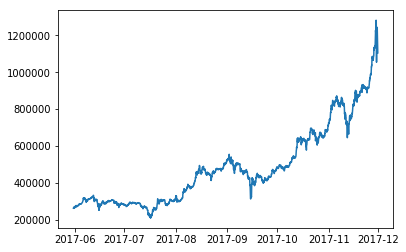

In [185]:
plt.plot(data['timestamp'], data['price'])

## 移動平均を取る

In [186]:
data['price_sma'] = data['price'].rolling(13).mean()
data = data.dropna()

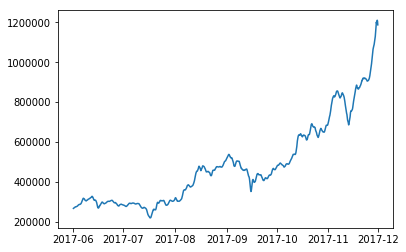

In [204]:
plt.plot(data['timestamp'], data['price_sma'])

## データを[2n時間前, 2(n-1)時間前, 2時間前]と[2時間後]に分離する
基準点（0時間）からの差分に変換する

In [197]:
n = 48

y = []
X = []

for i in range(0, len(data) - n):
    y.append(data.iloc[i + n]['price_sma'] - data.iloc[i + n - 1]['price_sma'])
    x = list(data.iloc[i:i + n - 2]['price_sma'].map(lambda d: d - data.iloc[i + n - 1]['price_sma']))
    X.append(x)


## 学習セットと評価セットに分離する

In [207]:
m = 2000
X_train = X[0:m]; X_test = X[m:]
y_train = y[0:m]; y_test = y[m:]
print(len(X_train), len(X_test))

2000 137


## 線形回帰モデルで学習する

In [199]:
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

## 結果を見る

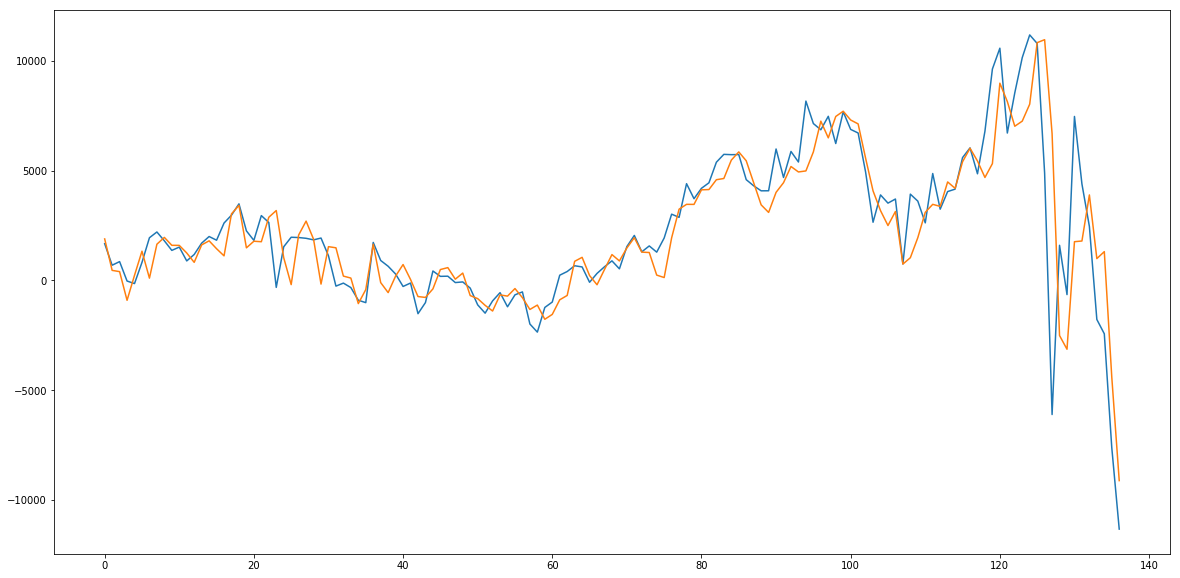

In [200]:
plt.figure(figsize=(20,10))
plt.plot(y_test)
plt.plot(y_pred)

In [201]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 3262643.70
Variance score: 0.71


# ビットコインでロジスティック回帰してみた

データ取得までは同じなので省略

In [209]:
n = 48

y = []
y_timestamp = []
X = []

for i in range(0, len(data) - n):
    y.append(int(data.iloc[i + n]['price_sma'] > data.iloc[i + n - 1]['price_sma']))
    x = list(data.iloc[i:i + n - 2]['price_sma'].map(lambda d: d - data.iloc[i + n - 1]['price_sma']))
    X.append(x)

In [210]:
m = 2000
X_train = X[0:m]; X_test = X[m:]
y_train = y[0:m]; y_test = y[m:]
print(len(X_train), len(X_test))

2000 137


In [211]:
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

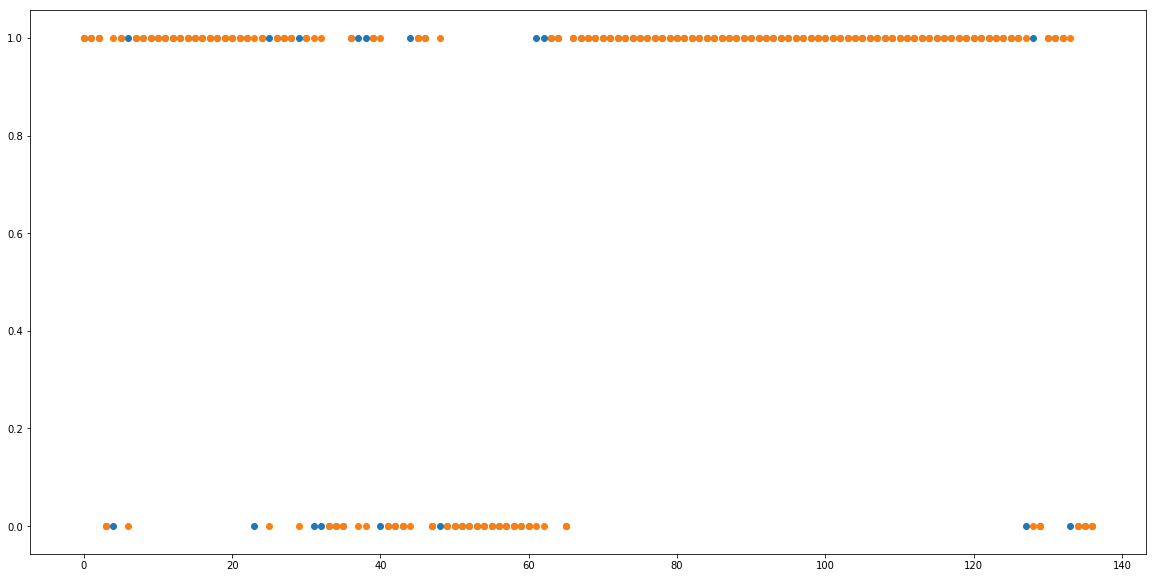

In [217]:
plt.figure(figsize=(20,10))
plt.scatter(range(0, len(y_test)), y_test)
plt.scatter(range(0, len(y_pred)), y_pred)

In [218]:
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean squared error: 0.12
Variance score: 0.32
